Overall packet delivery rate:  0.8942093541202673

latency statistics:
total number of packets: 3212
minimal latency time stamp: 2546996997
min latency: 50.0 ms
maximal latency time stamp: 2547069142
max latency: 444.0 ms
average latency: 140.74377334993773 ms
latency <90% 138.94809688581316

FPS statistics: 
FPS:  8.814018984040889
max FPS: 12.5
min FPS: 0.34518467380048323
Max interval:2897.0, (TX1, TX2): (2547319576.0,2547319688.0)  
FPS<90%: 10.047450284119543


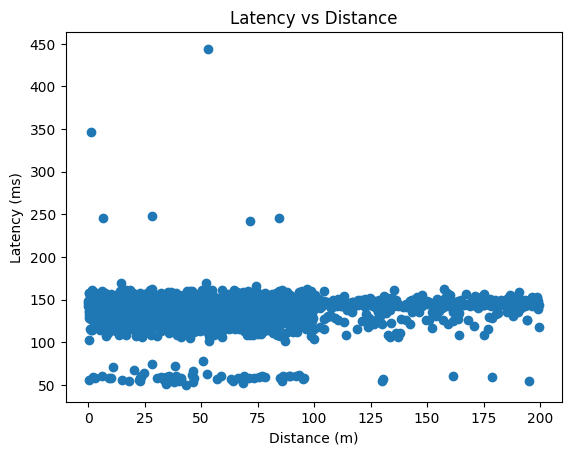

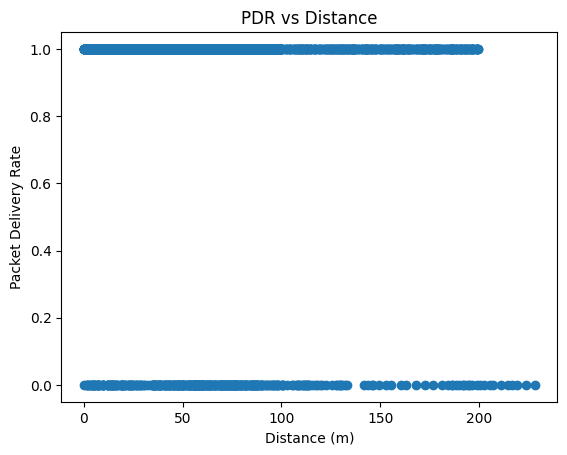

In [9]:
from itertools import zip_longest
from os import replace
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools as it

#create a function to find time
def find_time(f,r):
  for i in range(len(f)):
    if f[i][1] == r:
      return i

#read data from txt
file_front = open('front_loc.txt', 'r') # read the location of the front car
file_back = open('rear_loc.txt', 'r') # read ther location of the rear car

list_front = file_front.readlines() #convert to list
list_back = file_back.readlines()

# remove \n
list_f = [i.replace('\n','') for i in list_front]
list_r = [i.replace('\n','') for i in list_back]

#make a sublist of every data in the list
list_fnew = [i.split(',') for i in list_f]
list_rnew = [i.split(',') for i in list_r]

#convert to float
list_fnew = [[float(j) for j in i] for i in list_fnew]
list_rnew = [[float(j) for j in i] for i in list_rnew]

#remove package delivery 0
list_fnew2 = [i for i in list_fnew if i[0] != 0]

#packet data loss calculation
data_loss = len(list_rnew)/len(list_fnew2)
print("Overall packet delivery rate: ",data_loss)

#latency
latency = [] # in ms

for i in list_rnew: #append latency data from the raw data of rear vehicle to the latency list
  latency.append(i[1] - i[0])

# latency data
print('\nlatency statistics:')

print('total number of packets:', len(latency)) #total number of packets

print('minimal latency time stamp:', int(list_rnew[latency.index(min(latency))][0])) #minimal latency time stamp

min_latency = np.min(latency)
print('min latency:', min_latency, 'ms') #the minimal latency

print('maximal latency time stamp:', int(list_rnew[latency.index(max(latency))][0])) #maximal latency time stamp

max_latency = np.max(latency)
print('max latency:', max_latency, 'ms') #the maximal latency

avg_latency = np.mean(latency)
print('average latency:', avg_latency, 'ms') #average latency

#packet <90%
latency.sort()
print('latency <90%', np.mean(latency[0:int(len(latency)*0.9)])) #average of 90% of the total number of packet sorted ascendingly


#FPS
timestamps = [column[1]for column in list_rnew] #create a timestamp list
intervals = [timestamps[i+1] - timestamps[i] for i in range(len(timestamps)-1)]

FPS = [1000/interval for interval in intervals]#FPS = 1/time interval

print("\nFPS statistics: ")

print('FPS: ', 1000/(sum(intervals)/len(intervals)))#average FPS throughout the packet delivery

max_FPS = np.max(FPS)
print('max FPS:', max_FPS) #maximum FPS

min_FPS = np.min(FPS)
print('min FPS:', min_FPS) #minimum FPS

max_interval = np.max(intervals)

tx1 = timestamps[intervals.index(max_interval)-1]
tx2 = timestamps[intervals.index(max_interval)]

print(f"Max interval:{max_interval}, (TX1, TX2): ({tx1},{tx2})  ") #Time stamp maximum inteval

#FPS <90%
interval_90 =sorted(intervals)#sort the intervals ascendingly
interval_90_adjust = interval_90[0:int(len(interval_90)*0.9)]
FPS_90 = [1000/interval for interval in interval_90_adjust]#calculate the average 90% of the FPS data

print('FPS<90%:', np.mean(FPS_90)) #average of FPS 90%

#distance
list_fnew3 = [i for i in list_fnew2 if any(i[1] == j[0] for j in list_rnew)] #sort the values that both the sending and receiving car had
dlat =[] #change in latitude
dlon = [] #change in longitude
for i in list_fnew:
  for j in list_rnew:
    if i[1] == j[0]:
      dlat.append(float(j[2])-float(i[2])) #latitude of the rear car substract the latitude of the front car
      dlon.append(float(j[3])-float(i[3])) #longitude of the rear car substract the longitude of the front car

#earth radius
earth_radius = 6371009 #in meters

distance = []

for i in range(len(dlat)): #haversine formula
  lat1_rad = math.radians(float(list_fnew[i][2]))
  lat2_rad = math.radians(float(list_rnew[i][2]))
  a = math.sin(math.radians(dlat[i] / 2)) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(math.radians(dlon[i] / 2)) ** 2
  c = 2 * math.asin(math.sqrt(a))
  distance.append(earth_radius * c)

#Packet Delivery Ratio (PDR)

first_TX = find_time(list_fnew, list_rnew[0][0])
last_TX = find_time(list_fnew, list_rnew[-1][0])

list_fnew_PDR = list_fnew[first_TX: last_TX+1] #new list of front vehicle that starts and end exactly the same with rear vehicle
PDR = []

for i in list_fnew_PDR:
  if any(i[1] == j[0] for j in list_rnew):
    if i[0] == 1:
      PDR.append(1)
    else:
      PDR.append(0)
  else:
    PDR.append(0)

#(PDR) use gnss of previous rear vehicle data
distance_new = []
prev_lat2 = None
prev_lon2 = None
index_rnew = 0

for i in range(len(list_fnew_PDR)):
  lat1 = float(list_fnew_PDR[i][2])
  lon1 = float(list_fnew_PDR[i][3])

  if PDR[i] == 1 and index_rnew < len(list_rnew):
    lat2 = float(list_rnew[index_rnew][2])
    lon2 = float(list_rnew[index_rnew][3])
    prev_lat2 = lat2
    prev_lon2 = lon2
    index_rnew += 1
  elif PDR[i] == 0 and prev_lat2 is not None and prev_lon2 is not None:
    lat2 = prev_lat2
    lon2 = prev_lon2
  else:
    continue

  dlat = lat2 - lat1 #change in latitude
  dlon = lon2 - lon1 #change in longitude

  lat1_rad = math.radians(lat1)
  lat2_rad = math.radians(lat2)
  #haversine formula
  a = math.sin(math.radians(dlat / 2)) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(math.radians(dlon / 2)) ** 2
  c = 2 * math.asin(math.sqrt(a))
  distance_new.append(earth_radius * c)

PDR_sorted = [x for _,x in sorted(zip(distance_new,PDR))]
distance_new.sort()

#plot the distance against latency scattered graph
plt.scatter(distance,latency)
plt.xlabel('Distance (m)')
plt.ylabel('Latency (ms)')
plt.title('Latency vs Distance')
plt.show()

print(' ')

#plt.scatter(distance,FPS)
#plt.xlabel('Distance (m)')
#plt.ylabel('FPS (Hz)')
#plt.title('FPS vs Distance')
#plt.show()

#plot the distance against PDR graph
plt.scatter(distance_new,PDR_sorted)
plt.xlabel('Distance (m)')
plt.ylabel('Packet Delivery Rate')
plt.title('PDR vs Distance')
plt.show()



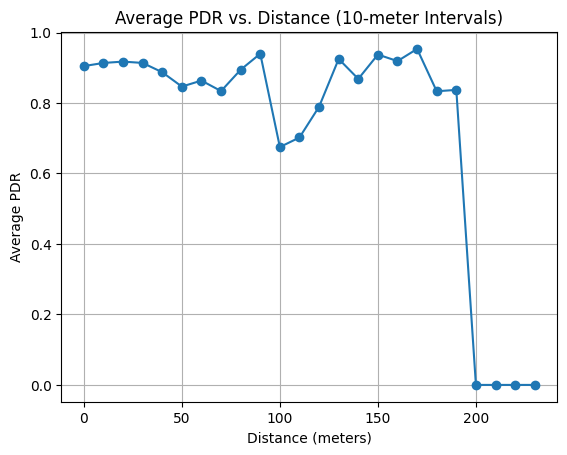

In [8]:
import matplotlib.pyplot as plt

# Categorize distances into 10-meter intervals
distance_bins = range(0, int(max(distance_new)) + 10, 10)
PDR_by_distance = {bin: [] for bin in distance_bins}

for distance, pdr in zip(distance_new, PDR_sorted):
    for bin in distance_bins:
        if bin <= distance < bin + 10:
            PDR_by_distance[bin].append(pdr)
            break

# Calculate average PDR for each distance interval
average_PDR = {bin: sum(pdr_values) / len(pdr_values) if pdr_values else 0
                for bin, pdr_values in PDR_by_distance.items()}

# Prepare data for plotting
x_values = list(average_PDR.keys())
y_values = list(average_PDR.values())

# Plot the graph
plt.plot(x_values, y_values, marker='o')
plt.xlabel('Distance (meters)')
plt.ylabel('Average PDR')
plt.title('Average PDR vs. Distance (10-meter Intervals)')
plt.grid()
plt.show()